## 0. 今日の量子コンピュータの問題

- Noisy Intermediate-Scale Quantum (NISQ) デバイス
    - 量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなる
    - 十分な量子ビット数ではない
- 量子デバイスは特別なゲート演算のみが用意されている
- 特定のqubits間の量子ビット演算(multi qubit operation)しか用意されていない
- それぞれの量子デバイスに対して、量子ソフトウェアツールキットが用意されてる


### 0-1. TKETとは
- Quantum Software Development Kit
- C++で実装
- pythonモジュール　`pytket`で利用可能
- 最適化コンパイラ：　ユーザーフレンドリーな回路→量子デバイスで実行可能な回路に変換可能
    - Language-agnostic (多くの量子プログラミングフレームワーク(qiskit, Cirq, etc)をサポート)
    - Retagetable (多くの量子デバイス(IBM, Honeywell, etc)をサポート)
    - Circuit Optimisation (量子計算時に生じるデバイスエラーの影響を最小化。デバイス依存＆デバイス非依存のものが実装)
    
<img src="./fig/tket1.png" width="750">


#### 参照
- [pytket ドキュメント](https://cqcl.github.io/tket/pytket/api/index.html)
- [pytket ユーザーマニュアル](https://cqcl.github.io/pytket/manual/index.html)
- [t|ket⟩ : A Retargetable Compiler for NISQ Devices](https://arxiv.org/abs/2003.10611)

### 0-2. 今回必要となる python パッケージ
Python 3.9.7で動作確認をしています。

|  パッケージ （version） |  概要  |
| :---- | :---- |
|  pytket==0.19.2  |  tketを利用するためのpython モジュール  ( available for python3.7 or higher )|
|  pytket-qiskit==0.22.0  |  qiskitを利用するためのpytket-extension  |
|  pytket-braket==0.16.0  |  Amazon Braketを利用するためのpytket-extension  |
|  pytket-qsharp==0.21.0  |  Azure Quantumを利用するためのpytket-extension  |
|  pytket-qulacs==0.16.0  |  Qulacsを利用するためのpytket-extension  |

<img src="fig/tket2.png" width="750">

環境にインストールされていない場合は、以下のセルの＃を取り除き、インストールしてください。

In [1]:
#!pip install pytket==0.19.2
#!pip install pytket-qiskit==0.22.0
#!pip install pytket-braket==0.16.0
#!pip install pytket-qsharp==0.21.0 #こちらのパッケージは.net等のインストールが必要です。詳しくは こちら を参照ください。
#!pip install pytket-qulacs==0.16.0
#!pip install pylatexenc #可視化のためのパッケージ

## 1. 量子回路を作成する
ここでは IBMの量子デバイスやシュミレーションを利用できる`qiskit`と`tket`でベル状態を作成する。

### 1-1. `qiskit`でベル状態を作成
$$ |\Psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$$

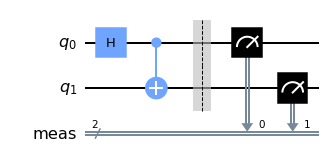

In [33]:
from qiskit import QuantumCircuit

qs_bell = QuantumCircuit(2)
qs_bell.h(0)
qs_bell.cx(0,1)
qs_bell.measure_all()

qs_bell.draw(output='mpl')

In [34]:
#from qiskit.tools.visualization import circuit_drawer
#circuit_drawer(qs_bell, output='mpl')

### 1-2. IBMが提供しているローカルシミュレータで計算

In [35]:
from qiskit import assemble, Aer
from qiskit.visualization import plot_histogram

In [36]:
#Aer.backends()

In [37]:
ibm_sim = Aer.get_backend('aer_simulator')

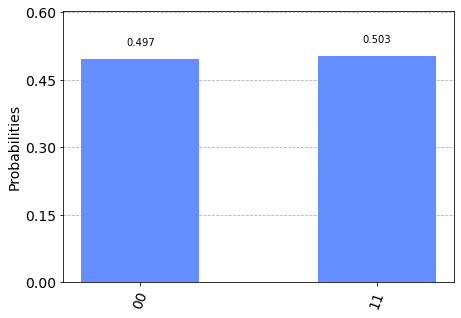

In [38]:
handle = ibm_sim.run(qs_bell, shots=1000)
counts = handle.result().get_counts()
plot_histogram(counts)

### 1-3. `braket`でベル状態を作成

In [39]:
from braket.devices import LocalSimulator
from braket.circuits import Circuit

# create the circuit
aws_bell = Circuit().h(0).cnot(0, 1)
print(aws_bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


### 1-4. Amazon Braketが提供しているローカルシミュレータで計算

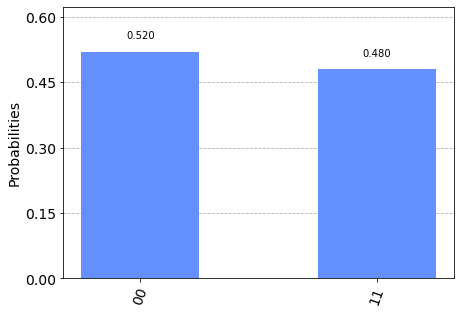

In [40]:
braket_sim = LocalSimulator(backend="braket_sv")
#braket_sim = LocalSimulator(backend="braket_dm")
braket_handle = braket_sim.run(aws_bell, shots=100)
counts = braket_handle.result().measurement_counts
plot_histogram(counts)

### 1-5. `tket`でベル状態を作成

In [44]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()

render_circuit_jupyter(bell)

### 1-6. `pytket-qiskit`でIBMが提供しているローカルシミュレータで計算

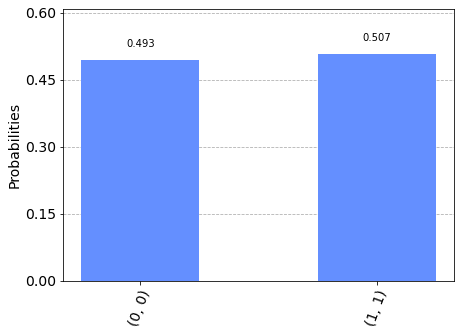

In [45]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

handle = backend.process_circuit(bell, n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

## 2. 量子回路の交換
pytketでは
- qiskitで記述した量子回路(`qiskit.QuantumCircuit`)からtketの量子回路のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路(`qiskit.QuantumCircuit`)のクラスに変換が可能
- tketで記述した量子回路と他の量子プログラミング言語での量子回路の交換が可能

参照：[pytket-extensions](https://cqcl.github.io/pytket-extensions/api/index.html) 

### 2-1. `qiskit`の量子回路から`tket`の量子回路に変換

In [12]:
from pytket.extensions.qiskit import qiskit_to_tk

In [13]:
bell2 = qiskit_to_tk(qs_bell)
bell2

[H q[0]; CX q[0], q[1]; Barrier q[0], q[1]; Measure q[0] --> meas[0]; Measure q[1] --> meas[1]; ]

In [14]:
render_circuit_jupyter(bell2)

### 2-2. `tket`の量子回路から`qiskit`の量子回路に変換

In [15]:
from pytket.extensions.qiskit import tk_to_qiskit

In [16]:
qs_bell2 = tk_to_qiskit(bell)
qs_bell2

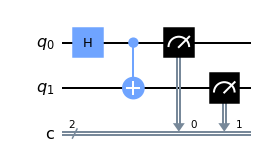

In [17]:
qs_bell2.draw('mpl')

In [18]:
#from pytket.extensions.braket import tk_to_braket
#tk_to_braket(bell)

## 3. 量子回路の最適化
例えば、Hゲートを同じビットに連続して作用させるとゲート操作をしていないのと恒等な量子状態が得られます。
<img src="fig/circ.png" width="500">

量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなるNISQ デバイスでは左辺のような状況は除去したい。

その他にも下記のような恒等な関係があります。
<img src="fig/relation.png" width="700">

### 3-1. PauliSimp 関数を利用した、量子回路の最適化
tketには量子回路を最適化する様々な機能が用意されている。
ここでは、PauliSimp 関数を利用した回路の最適化を行う。

（PauliSimp 関数：Pauli ゲートとCliffordゲートで表現された量子回路を出力）

ランダムな量子回路を作成し、回路の深さとCXの深さを数える。

In [19]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=8, n_pauli_gadgets=300, max_entangle=5
)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ)

Circuit depth:  994
CX depth:  675


PauliSimp 関数を使って、量子回路の最適化

In [20]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
print('Circuit depth: ', circx.depth())
print('CX depth: ', circx.depth_by_type(OpType.CX))
#render_circuit_jupyter(circx)

Circuit depth:  846
CX depth:  541


## 4. pytket-extensionで、IBM Quantum、Amazon Braket、Azure Quantumを利用する
### 下記のスクリプトはそれぞれのクラウドで<span style="color: red; ">有料の操作</span>となることがありますので、ご注意ください

### 4-1. pytket-qiskitを利用して、IBM Quantumのシミュレータや実機にアクセス

In [68]:
path = 'ibm-token'
f = open(path)
ibm_token = f.read()
f.close()

In [69]:
from pytket.extensions.qiskit.backends.config import set_ibmq_config
set_ibmq_config(ibmq_api_token=ibm_token)

In [70]:
from pytket.extensions.qiskit import IBMQBackend
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [77]:
#IBMQBackend.available_devices()

In [27]:
#ibm_backend = IBMQBackend("ibmq_lima")
#ibm_backend = IBMQBackend("ibmq_qasm_simulator")
# AerBackend to emulate the behaviour of IBMQBackend. Requires a valid IBMQ account.
ibm_backend = IBMQEmulatorBackend("ibmq_lima")

In [28]:
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

ibm_backend.compile_circuit(bell)
render_circuit_jupyter(bell)


In [29]:
ibm_handle = ibm_backend.process_circuit(bell, n_shots =1000)

In [30]:
ibm_result = ibm_backend.get_result(ibm_handle)

Job Status: job has successfully run


In [31]:
#ibm_backend.cancel(ibm_handle)

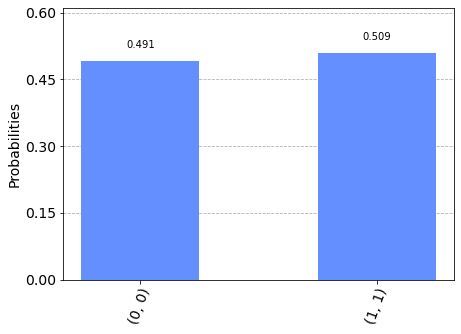

In [32]:
from qiskit.visualization import plot_histogram
plot_histogram(ibm_result.get_counts())

### 4-2. pytket-braketを利用して、Amazon Braketのシミュレータや実機にアクセス

In [78]:
#フォルダーにアクセスキー等の情報ファイルaws-keyを作成し、読み込む
path = 'aws-key'
f = open(path)
aws_access_key_id, aws_secret_access_key, s3_name, bucket_key= [s.strip() for s in f.readlines()]
f.close()

In [88]:
# Braket clientを作成し、Sessionを開始
import boto3
from braket.aws import AwsSession
boto_session = boto3.Session(
    aws_access_key_id= aws_access_key_id,
    aws_secret_access_key= aws_secret_access_key,
    region_name= 'us-east-1'
)
aws_session = AwsSession(boto_session=boto_session)

In [116]:
#aws_session.search_devices()

In [81]:
# backend の選択
from pytket.extensions.braket import BraketBackend

# ionQ   arn:aws:braket:::device/qpu/ionq/ionQdevice, region: us-east-1
# aws_backend = BraketBackend(device='ionQdevice', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'ionq', aws_session=aws_session)
# Aspen-11   arn:aws:braket:::device/qpu/rigetti/Aspen-11 #Aspen-11, region: us-west-1
# aws_backend = BraketBackend(device='Aspen-11', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'rigetti', aws_session=aws_session)
# SV1    sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/sv1'     #SV1, region:
# aws_backend = BraketBackend(device='sv1', s3_bucket=s3_name , s3_folder = bucket_key, aws_session=aws_session)
# TN1   sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/tn1'    #TN1, region: us-west-2, us-east-1
# aws_backend = BraketBackend(device='tn1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# DM1   sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/dm1'    #DM1, region: 
# aws_backend = BraketBackend(device='dm1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# Local sv1 simulator
aws_backend = BraketBackend(local = True)

In [53]:
#aws_backend.backend_info

In [54]:
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
render_circuit_jupyter(bell)

# backend に用意されているゲートで量子回路を表現
aws_backend.compile_circuit(bell)
render_circuit_jupyter(bell)

In [55]:
aws_handle = aws_backend.process_circuit(bell, n_shots =1000)

In [56]:
aws_result = aws_backend.get_result(aws_handle)
print(aws_result.get_counts())

Counter({(1, 1): 512, (0, 0): 488})


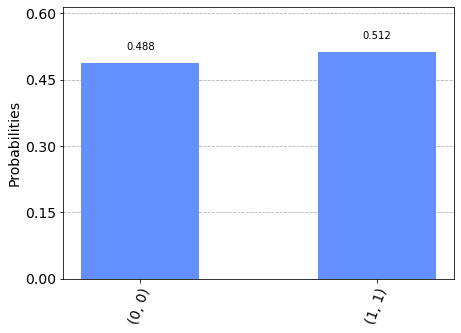

In [57]:
from qiskit.visualization import plot_histogram
plot_histogram(aws_result.get_counts())

### 4-3. pytket-qsharpを利用して、Azure Quantumのシミュレータや実機にアクセス

In [58]:
path = 'azure-key'
f = open(path)
resource_id = [s.strip() for s in f.readlines()]
f.close()

In [93]:
from pytket.extensions.qsharp import set_azure_config
set_azure_config(resourceId=resource_id, location="eastus")

In [110]:
# Azure Qauntum上のIonQシミュレータを利用する
#from pytket.extensions.qsharp import AzureBackend
#azure_backend = AzureBackend(target_name='ionq.simulator')

In [112]:
# Azure Qauntumが提供しているローカルシミュレータを利用する
from pytket.extensions.qsharp import QsharpSimulatorBackend, AzureBackend
azure_backend = QsharpSimulatorBackend()
from qiskit.visualization import plot_histogram

In [113]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
bell = Circuit(2)
bell.H(0).CX(0,1)
#bell.measure_all()
render_circuit_jupyter(bell)

#azure_backend.compile_circuit(bell)
#render_circuit_jupyter(bell)

In [114]:
result = azure_backend.run_circuit(bell.measure_all(), n_shots=1000)

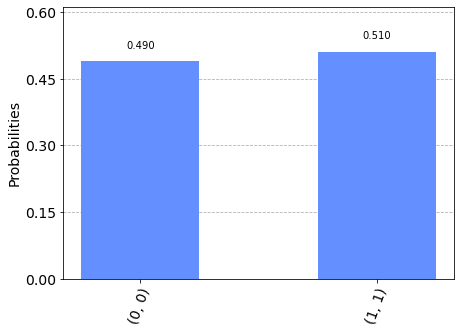

In [115]:
counts = result.get_counts()
plot_histogram(counts)

### 4-4. pytket-qulacs を利用して、Qulacsのシミュレータにアクセス

In [59]:
from pytket.extensions.qulacs import QulacsBackend
qulacs_backend = QulacsBackend()

In [68]:
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

qulacs_backend.compile_circuit(bell)
render_circuit_jupyter(bell)

In [72]:
qulacs_handle = qulacs_backend.process_circuit(bell, n_shots=1000)

In [73]:
qulacs_result = qulacs_backend.get_result(qulacs_handle)
print(qulacs_result.get_counts())

Counter({(0, 0): 521, (1, 1): 479})


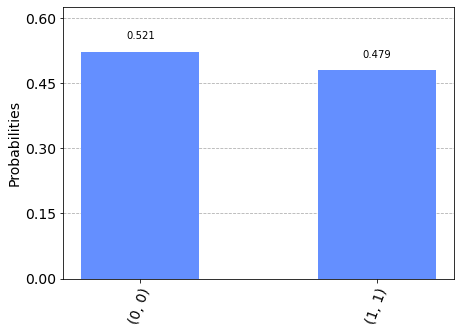

In [74]:
counts = qulacs_result.get_counts()
plot_histogram(counts)

### Cambridge Quantumの情報
- ウェブサイト（英語）： https://cambridgequantum.com/
- 各種技術詳細： https://cambridgequantum.com/our-technology/
- 学術論文： https://cambridgequantum.com/our-publications/　
- プレスリリース（ 日本語 ）： https://japan.zdnet.com/company/30001168/release/　
- Twitter（ 日本語 ）： https://twitter.com/cqc_japan
- CQ日本チーム主催の勉強会（日本語）： https://cambridgequantum.connpass.com/
- 問い合わせ先（日本語）: cqcjapan.business @ cambridgequantum.com

### 受講後のアンケートのお願い
お手数ではございますが、受講後のアンケートにご協力ください。個人情報の取得はございません。

[受講後アンケート](https://forms.gle/gNopgHLJYGcAZhLh7)

<img src="./fig/アンケートQSRH.png" width="200">